# Project Understanding
<p>
    The goal of this project is to build a dataset of atleast 1000 articles from page https://kosmonautix.cz/. The dataset should contain text, title, author and date of creation for each article. Then a DNN for classification of author should be constructed.
</p>

# Data Collection
<p>
    1000 articles are collected using script `../src/scrapper/main.py` and stored into file `../data/articles.json`. Sleep time is set to 2 seconds between each request so we don't get blocked.
</p>

In [1]:
# commented in case we rerun the notebook to not overwrite our data
#!ipython ../src/scrapper/main.py 1000 ../data/articles.json 2

# Data Loading
<p>
    During this phase we load the collected data.
</p>

In [2]:
# constants
DATA_PATH = "../data/articles.json"
SEED = 42

In [3]:
# base imports
from typing import List, Tuple, Optional, Union, Dict
import re
import json

# ml imports
from numpy.random import seed
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, StandardScaler,
                                   MinMaxScaler, MaxAbsScaler, RobustScaler)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             f1_score, precision_score, recall_score,
                             cohen_kappa_score, confusion_matrix
                            )

# NN imports
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

# nlp imports
from stop_words import get_stop_words

# plotting imports
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff

In [4]:
# seed
seed(SEED)
tf.random.set_seed(SEED)

# plotting config
pio.renderers.default = "png"

In [5]:
def load_json_data(path : str) -> pd.DataFrame:
    """Loads json data from file with given path and returns a pandas dataframe."""
    
    data : pd.DataFrame = pd.read_json(path)
    # join together paragraphs and get paragraph count
    data["content"] = data["content_paragraphs"].apply(lambda l: " ".join(l))
    data["paragraph_count"] = data["content_paragraphs"].apply(len)
    data.drop(columns=["content_paragraphs"], inplace=True)
    
    # adjust author to be a categorical value, since it is an output attribute
    data["author"] = pd.Categorical(data["author"])
    
    return data

df = load_json_data(DATA_PATH)
df.columns.values

array(['title', 'author', 'date', 'content', 'paragraph_count'],
      dtype=object)

<p>
    The data collected contains `date` attribute. We want to predict authors of new articles from article history, so we need to split the data according to the date.
</p>

In [6]:
df["date"]

0     2021-01-02
1     2021-01-02
2     2021-01-01
3     2021-01-01
4     2021-01-01
         ...    
995   2019-09-03
996   2019-09-03
997   2019-09-02
998   2019-09-02
999   2019-09-01
Name: date, Length: 1000, dtype: datetime64[ns]

<p>
    The data seems to be sorted in the reverse order. So we sort by the date in ascending order.
</p>

In [7]:
df.sort_values("date", inplace=True, ascending=True)
df["date"]

999   2019-09-01
998   2019-09-02
997   2019-09-02
996   2019-09-03
995   2019-09-03
         ...    
4     2021-01-01
3     2021-01-01
2     2021-01-01
1     2021-01-02
0     2021-01-02
Name: date, Length: 1000, dtype: datetime64[ns]

<p>
    We split the data into training, validation and testing (evaluation) datasets. Since we don't have much data, we split the dataset with ratio 8:1:1.
</p>

In [8]:
def train_test_valid_split(df: pd.DataFrame, test_size : int, valid_size : int, random_state : int = 0,
                           shuffle : bool = True) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Splits the dataset into train, validation and test dataframes and returns them in given order."""
    
    train_size = 1 - (test_size + valid_size)
    train_df, valid_and_test_df = train_test_split(df, train_size=train_size, random_state=random_state, shuffle=shuffle)
    
    coeff = 1 / (test_size + valid_size)
    valid_df, test_df = train_test_split(valid_and_test_df, test_size=test_size*coeff, random_state=random_state, shuffle=shuffle)
    return train_df, valid_df, test_df

train_df, validation_df, test_df = train_test_valid_split(df, 0.1, 0.1, shuffle=False)
print(f"Training data rows (entries): {train_df.shape[0]}")
print(f"Validation data rows (entries): {validation_df.shape[0]}")
print(f"Test data rows (entries): {test_df.shape[0]}")

Training data rows (entries): 800
Validation data rows (entries): 100
Test data rows (entries): 100


# Data Understanding and Data Preparation
<p>
    We perform exploratory data analysis of the training dataframe and prepare the whole dataset for modeling.
</p>

## Attribute Understanding
<p>
    We summarize the attributes of the dataset.
</p>

In [9]:
train_df

,title,author,date,content,paragraph_count
999,Kosmotýdeník 363 (26.8. – 1.9.),Lukáš Houška,2019-09-01,"Musíte uznat, že oproti minulým dvěma týdnům, ...",40
998,Jméno roveru pro Mars a instalace helikoptéry,Dušan Majer,2019-09-02,"Máte návrh, jak by se mohlo jmenovat americké ...",19
997,Vesmírné výzvy – srpen 2019,Dušan Majer,2019-09-02,Další měsíc uběhl jako voda a je čas na jeho r...,4
996,Svět nad planetou (47. díl),Ondřej Šamárek,2019-09-03,"S tím, jak se blížil moment příletu nového mod...",27
995,Zničená rampa na Chomeneího kosmodromu,Roman Vyhnánek,2019-09-03,Íránci se letos pokoušejí opakovaně vypustit n...,10
...,...,...,...,...,...
204,ŽIVĚ A ČESKY: Odkládaná 12. várka Starlinků,Dušan Majer,2020-09-28,V posledních dnech jsme zažívali celou řadu od...,2
203,ŽIVĚ A ČESKY: Odložená Delta IV Heavy čeká,Dušan Majer,2020-09-28,Na začátku září jsme se těšili na působivý sta...,4
201,Drobný posun mise Crew-1,Dušan Majer,2020-09-29,NASA a SpaceX se dohodly na posunutí startu pr...,3
202,Perseverance využije na Marsu i rentgenové záření,Dušan Majer,2020-09-29,Vozítko Perseverance ještě několik měsíců pole...,11


In [10]:
def get_python_type(series : pd.Series) -> type:
    """Gets python type from a given series (column)."""
    
    series = series.dropna()
    # when all values are None (NAN)
    if len(series) == 0:
        return type(None)
    return type(series.values[0])

def get_python_type_list(df : pd.DataFrame) -> List[type]:
    """Gets list of all underlying python types from dataframe into a list."""
    
    types = []
    for col in df.columns:
        types.append(get_python_type(df[col]))
    return types

def get_type_table(df : pd.DataFrame) -> pd.DataFrame:
    """Creates a table that contains pandas dtype of each object but also python type of each object."""
    
    result = pd.DataFrame(df.dtypes, columns=["pandas_dtype"])
    result["python_type"] = get_python_type_list(df)
    return result

get_type_table(train_df)

,pandas_dtype,python_type
title,object,<class 'str'>
author,category,<class 'str'>
date,datetime64[ns],<class 'numpy.datetime64'>
content,object,<class 'str'>
paragraph_count,int64,<class 'numpy.int64'>


### Summary
<p>
    <ul>
        <li> 
            The whole dataset contains 1000 articles. The training dataframe contains 800 articles, the validation dataframe contains 100 articles and testing (evaluation) dataframe contains 100 articles. 
        </li>
        <li>
            There are 4 input attributes:
            <ul> 
                <li>
                    Title - represents the title of an article; string data type
                </li>
                <li>
                    Date - represents an article's release date; datetime data type
                </li>
                <li>
                    Content - represents text content of an article; string data type
                </li>
                <li>
                    Paragraph count - represents count of paragraphs; int data type
                </li>
            </ul>
        </li>
        <li>
            There is one output attribute (label):
            <ul> 
                <li>
                    Author - author of an article; string data type
                </li>
            </ul>
        </li>
    </ul>
</p>

## Missing Values
<p>
    We check whether some values are not missing.
</p>

In [11]:
def count_empty(array) -> int:
    """Counts all empty objects inside an array."""
    
    return len([*filter(lambda e: len(e) == 0, array)])

def get_missing_and_empty_table(df) -> pd.DataFrame:
    """Gets pandas dataframe table with stats about missing and empty values."""
    
    result = pd.DataFrame(df.isna().sum(), columns=["missing_values"])
    result["%missing_values"] = round(result["missing_values"] / len(df) * 100, 2)
    result["empty_values"] = df.apply(lambda s: count_empty(s) if pd.api.types.is_object_dtype(s) else 0)
    result["%empty_values"] = round(result["empty_values"] / len(df) * 100, 2)
    result["missing_or_empty_values"] = result["missing_values"] + result["empty_values"]
    result["%missing_or_empty_values"] = round(result["missing_or_empty_values"] / len(df) * 100, 2)
    return result

get_missing_and_empty_table(train_df)

,missing_values,%missing_values,empty_values,%empty_values,missing_or_empty_values,%missing_or_empty_values
title,0,0.0,0,0.0,0,0.0
author,0,0.0,0,0.0,0,0.0
date,0,0.0,0,0.0,0,0.0
content,0,0.0,0,0.0,0,0.0
paragraph_count,0,0.0,0,0.0,0,0.0


<p>
    There is no missing or empty data in the training dataset.
</p>

## Data Quality
<p>
    During this phase assess quality of the dataset. In order to assess dataset we check:
    <ul>
        <li> syntactic and semantic accuracy of attributes </li>
        <li> completeness, timeliness and representativness of dataset </li>
        <li> distributions of attributes (univariate analysis) </li>
        <li> class balance of output variables </li>
    </ul>
</p>

### Author

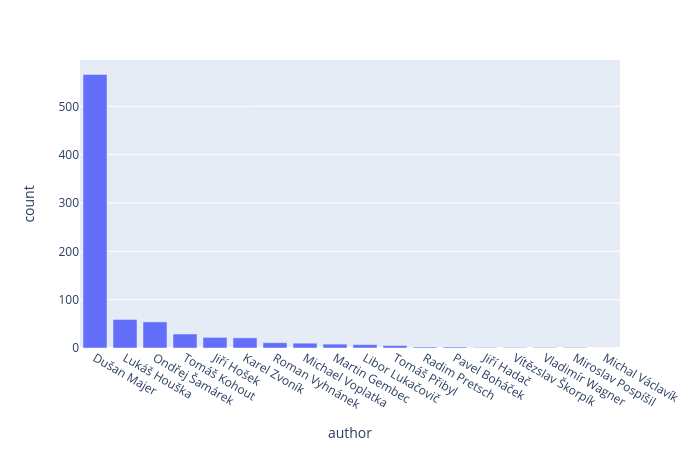

In [12]:
def get_count_table(series: pd.Series, attribute_name: str) -> pd.DataFrame:
    """Gets a count table (dataframe) for given series."""
    
    series = series.rename(attribute_name)
    result = series.value_counts().reset_index()
    result.rename(columns={attribute_name: "count", "index": attribute_name}, inplace=True)
    return result

fig = px.bar(get_count_table(train_df["author"], "author"), x="author", y="count")
fig.show()

<p>
    The output class of author is heavily imbalanced. There are 574 articles from `Dušan Majer`. However we have many authors, including `Miroslav Pospíšil`, `Michal Václavík`, and others that have written only one article each.
</p>

### Title

In [13]:
print(f"Unique titles: {len(train_df['title'].unique())}")

Unique titles: 800


<p>
    We can see that each article has a unique title.
</p>

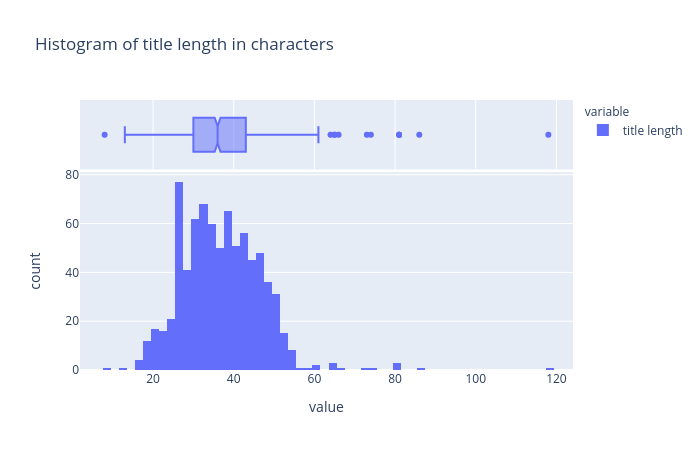

In [14]:
title_len = train_df["title"].apply(len)
title_len.rename("title length", inplace=True)
fig = px.histogram(title_len, title=f"Histogram of title length in characters", marginal="box")
fig.show()

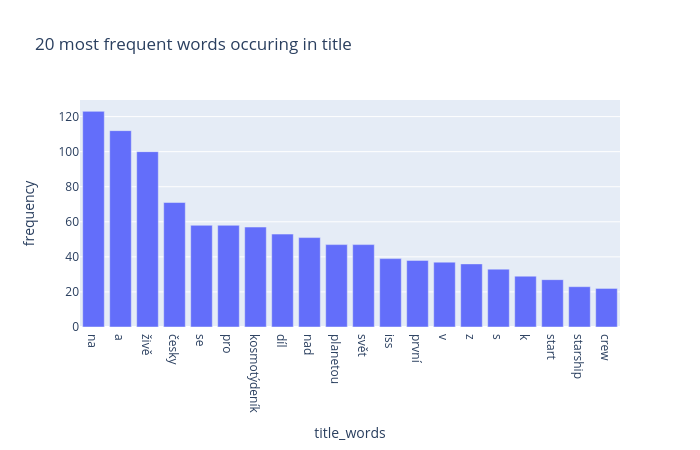

In [15]:
def get_freq_df(series : pd.Series, index_name : str) -> pd.DataFrame:
    """Converts series of lists into a frequency dataframe with occurences of elements inside given lists."""
    
    all_values = sum(series.values, [])
    series_counts = pd.Series(all_values).value_counts()
    result = pd.DataFrame(series_counts, columns=["frequency"])
    result.index.name = index_name
    return result

def remove_non_alpha(s : str) -> str:
    """Removes characters that are not alpha from a string."""
    
    return "".join([c if c.isalpha() else "" for c in s])

def get_alpha_words(text: str) -> List[str]:
    """Get all alpha words from a text."""
    
    words = text.split()
    words = [remove_non_alpha(s.lower()) for s in words]
    return [*filter(lambda s: s != "", words)]

title_words = train_df["title"].apply(get_alpha_words)
# remove non-alpha from words and filter out empty words
title_words_freqs = get_freq_df(title_words, "title_words")
fig = px.bar(title_words_freqs.reset_index()[:20], x="title_words",
             y="frequency", title="20 most frequent words occuring in title")
fig.show()

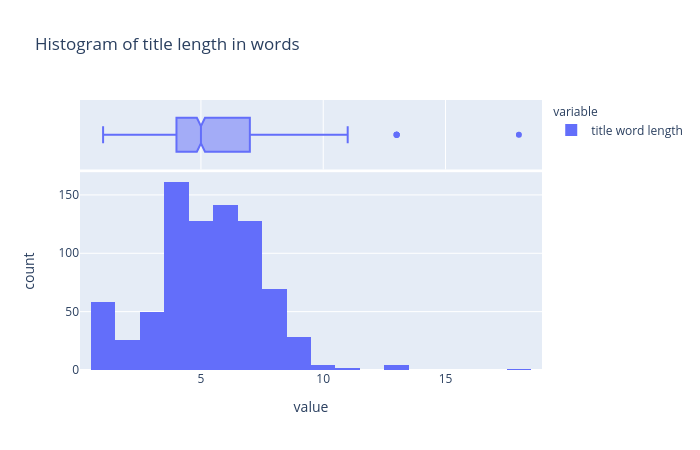

In [16]:
title_word_len = title_words.apply(len)
title_word_len.rename("title word length", inplace=True)
fig = px.histogram(title_word_len, title=f"Histogram of title length in words", marginal="box")
fig.show()

<p>
    The median of title word length is 5. Most titles have 4 words, however there are two outliers which hae 13 and 18 words each.
</p>

### Date

In [17]:
get_count_table(train_df["date"], "date")

,date,count
0,2020-06-26,3
1,2020-09-01,3
2,2019-09-25,3
3,2020-02-17,3
4,2020-07-23,3
...,...,...
391,2019-11-26,2
392,2020-09-14,2
393,2020-07-14,2
394,2020-09-30,1


<p>
    As we can usee usually 2 or 3 articles are released each day in the training dataset.
</p>

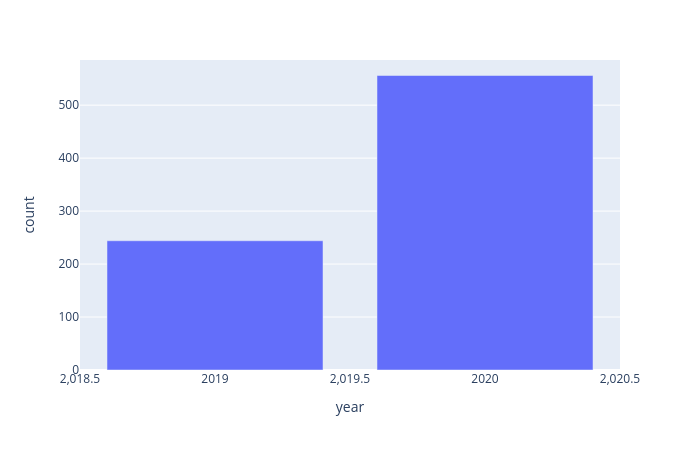

In [18]:
fig = px.bar(get_count_table(train_df["date"].dt.year, "year"), x="year", y="count")
fig.show()

<p>
    We have more data for the year 2020. The dataset has recent data, so predicting new articles should not be a problem. We collected each article for year 2020 and many articles for year 2019, so the dataset should be representative.
</p>

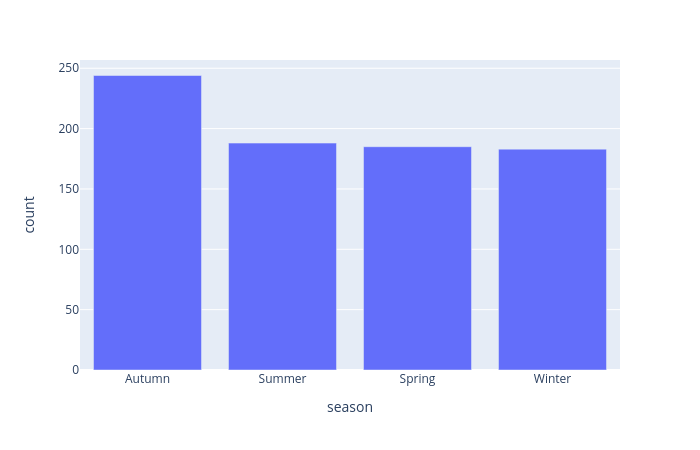

In [19]:
def month_to_season_index(month : int) -> int:
    """Convers number of month (from 1 to 12) to a season index from 1 to 4."""
    
    if month < 1 or month > 12:
        return -1
    return 1 + (month % 12) // 3

def month_to_season(month: int, seasons: List[str] = ["Winter", "Spring", "Summer", "Autumn"]) -> str:
    """Converts number of month (from 1 to 12) to a season."""
    
    season_index = month_to_season_index(month)
    if season_index == -1:
        return "Unknown"
    return seasons[season_index - 1]

fig = px.bar(get_count_table(train_df["date"].dt.month.apply(month_to_season), "season"), x="season", y="count")
fig.show()

<p>
    There are some seasonal patterns in the data. Most articles are released in autumn, followed by summer. The least amount of articles is released in winter.
</p>

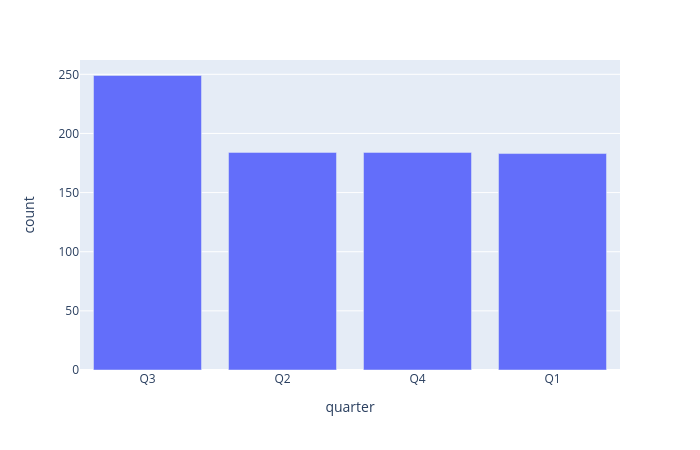

In [20]:
def month_to_quarter(month: int) -> int:
    """Converts number of month (from 1 to 12) to an int representing a quarter."""
    
    if month < 1 or month > 12:
        return -1
    return (month - 1) // 3 + 1

def month_to_quarter_str(month: int) -> str:
    """Converts number of month (from 1 to 12) to a quarter string."""
    
    quarter = month_to_quarter(month)
    if quarter == -1:
        return "unknown"
    return f"Q{quarter}"

fig = px.bar(get_count_table(train_df["date"].dt.month.apply(month_to_quarter_str), "quarter"), x="quarter", y="count")
fig.show()

<p>
    However, when we look at article releases for quarters we can see that the second half of the year most articles are released. Especially during the last Q3 most articles are released, followed by Q4.
</p>

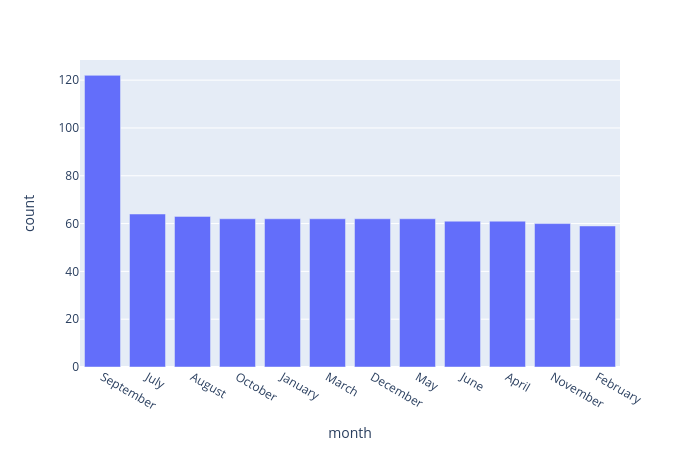

In [21]:
fig = px.bar(get_count_table(train_df["date"].dt.month_name(), "month"), x="month", y="count")
fig.show()

<p>
    Looking more closely at months, we can see that the month with most articles is September, while the other months have approximately the same amount of articles released.
</p>

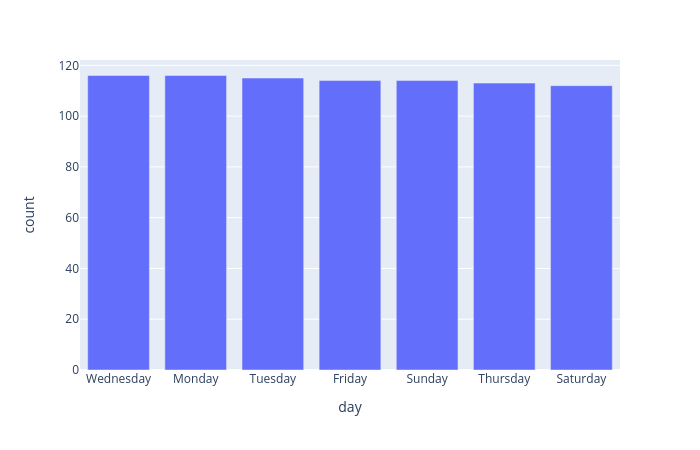

In [22]:
fig = px.bar(get_count_table(train_df["date"].dt.day_name(), "day"), x="day", y="count")
fig.show()

<p>
    Looking at days, we can see that most of the articles are released on Wednesday. The least amount of articles is released on Saturday. However the amount of articles released does not differ much between all the days.
</p>

### Paragraph count

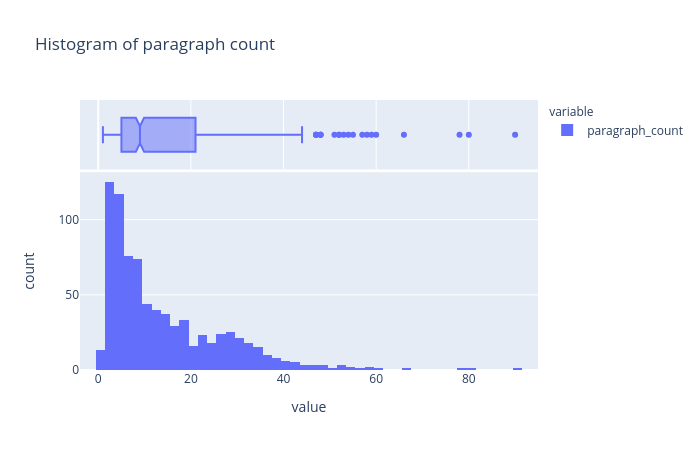

In [23]:
fig = px.histogram(train_df["paragraph_count"], title=f"Histogram of paragraph count", marginal="box")
fig.show()

### Content
<p>
    First we inspect some random articles' contents to spot errors.
</p>

In [24]:
def print_content(df : pd.DataFrame, index : int, max_chars : int = 2000):
    """Prints content attribute of df with given index."""
    
    if index in df.index:
        content = df["content"][index]
        print(content[:max_chars])
    
print_content(train_df, 300)

Americká sonda Dawn přinesla vědcům nevídané detailní pohledy na trpasličí planetu Ceres, která obíhá v hlavním pásu planetek mezi Marsem a Jupiterem. V říjnu 2018, kdy se mise chýlila ke konci, prolétávala Dawn méně než 35 kilometrů nad terénem. Její přístroje tak mohly pořídit mimořádně detailní měření povrchu pod sondou včetně tajemných světlých oblastí, které Ceres proslavily i mezi laickou veřejností. Už relativně krátce po jejich objevu vědci zjistili, že bílou barvu dávají těmto místům usazeniny uhličitanu sodného (sody na praní). Předpokládalo se, že tyto usazeniny velmi pravděpodobně vytvořila voda, která prosákla na povrch a vypařila se. Soli, které v ní byly rozpuštěné, tu však zůstaly a vytvořily krustu, která dobře odráží světlo. Jenže nikdo neměl jistou odpověď na otázku, odkud se tato tekutina vzala. Poté, co vědci analyzovali data nasbíraná před koncem mise, mohli přinést odpověď i na tuto otázku – kapalina pocházela z hloubkového podpovrchového zásobníku vody s rozpušt

In [25]:
print_content(train_df, 400)

V pátek ve 13:35 našeho času by měla začít další kosmická vycházka. Ale na dvojici amerických astronaut nečeká žádná pohodová vycházka. Při zhruba sedmihodinovém výstupu do volného prostoru si pěkně máknou – zahájí totiž závěrečnou fázi čtyři roky probíhající výměny staničních nikl-vodíkových akumulátorů za nové lithium-iontové. V našem článku najdete okno přehrávače NASA TV, která bude vysílat celý výstup. A jak oba pány poznáte? Chris Cassidy bude mít (jakožto velitel výstupu) skafandr opatřený červeným pruhy. Robert Behnken pak oblékne čistě bílý skafandr. Místo složitého popisu, co vlastně na oba muže čeká, Vám doporučím pustit si tohle zhruba čtyřminutové video. V něm najdete animaci, která přehledně popisuje plánovaný průběh výstupu. Moc hezky je zde popsáno, jak bude probíhat odstraňování starých akumulátorů, instalace adaptéru, nebo kam se přesunou jednotlivé staré akumulátory.


<p>
    We can see that the content needs to be cleaned. We remove all the czech stop words, replace some symbols by space, remove `zdroje` with urls, add missing spaces and replace some bad symbols that we don't need during feature engineering.
</p>

In [26]:
STOPWORDS = set(get_stop_words("czech"))
BAD_SYMBOLS_RE = re.compile("[^ěščřžýáíéóúůďťňĎŇŤŠČŘŽÝÁÍÉÚŮa-z0-9 .!?]")
SPACE_SYMBOLS_RE = re.compile("[/(){}\[\]\|@,;-_]")
# URL RE taken and modified from https://docs.microsoft.com/en-us/previous-versions/msp-n-p/ff650303(v=pandp.10)?redirectedfrom=MSDN
URL_RE = re.compile("(zdroje?:?)? (ht|f)tp(s?)\:\/\/[0-9a-zA-Z]([-.\w]*[0-9a-zA-Z])*(:(0-9)*)*(\/?)([a-zA-Z0-9\-\.\?\,\'\/\\\+&amp;%\$#_]*)?")
FIND_MISSING_SPACES_RE = re.compile("([.?!]+)(.)")

def clean_content(content: str) -> str:
    """Cleans content text and returns it."""
    
    content = content.lower()
    # remove urls including possible word 'zdroj'
    content = URL_RE.sub("", content)
    # replace some symbols with a space
    content = SPACE_SYMBOLS_RE.sub(" ", content) 
    # remove bad symbols
    content = BAD_SYMBOLS_RE.sub("", content)
    # add spaces if ?.! is not followed by a space
    content = FIND_MISSING_SPACES_RE.sub(r"\1 \2", content)
    # remove stopwords
    content = " ".join(word for word in content.split() if word.strip() != "" and word not in STOPWORDS)
    return content

train_df.loc[:, "content"] = train_df["content"].apply(clean_content)
validation_df.loc[:, "content"] = validation_df["content"].apply(clean_content)
test_df.loc[:, "content"] = test_df["content"].apply(clean_content)

print_content(train_df, 300)

americká sonda dawn přinesla vědcům nevídané detailní pohledy trpasličí planetu ceres obíhá vhlavním pásu planetek marsem ajupiterem. vříjnu 2018 mise chýlila konci prolétávala dawn méně 35 kilometrů terénem. přístroje mohly pořídit mimořádně detailní měření povrchu pod sondou včetně tajemných světlých oblastí ceres proslavily imezi laickou veřejností. relativně krátce objevu vědci zjistili bílou barvu dávají těmto místům usazeniny uhličitanu sodného sody praní . předpokládalo tyto usazeniny velmi pravděpodobně vytvořila voda prosákla povrch avypařila se. soli vní rozpuštěné tu však zůstaly avytvořily krustu dobře odráží světlo. jenže nikdo jistou odpověď otázku odkud tato tekutina vzala. poté vědci analyzovali data nasbíraná koncem mise mohli přinést odpověď ina tuto otázku kapalina pocházela zhloubkového podpovrchového zásobníku vody srozpuštěnými solemi. měřením gravitačního pole ceres podařilo nepřímo nahlédnout vnitřní struktury této trpasličí planety. ztěchto dat mohli vyčíst zás

In [27]:
print_content(train_df, 400)

v pátek 1335 našeho času by měla začít další kosmická vycházka. dvojici amerických astronaut nečeká žádná pohodová vycházka. při zhruba sedmihodinovém výstupu volného prostoru si pěkně máknou zahájí totiž závěrečnou fázi roky probíhající výměny staničních niklvodíkových akumulátorů nové lithiumiontové. vnašem článku najdete okno přehrávače nasa tv vysílat celý výstup. ajak oba pány poznáte chris cassidy jakožto velitel výstupu skafandr opatřený červeným pruhy. robert behnken oblékne čistě bílý skafandr. místo složitého popisu oba muže čeká doporučím pustit si zhruba čtyřminutové video. vněm najdete animaci přehledně popisuje plánovaný průběh výstupu. hezky zde popsáno probíhat odstraňování starých akumulátorů instalace adaptéru přesunou jednotlivé staré akumulátory.


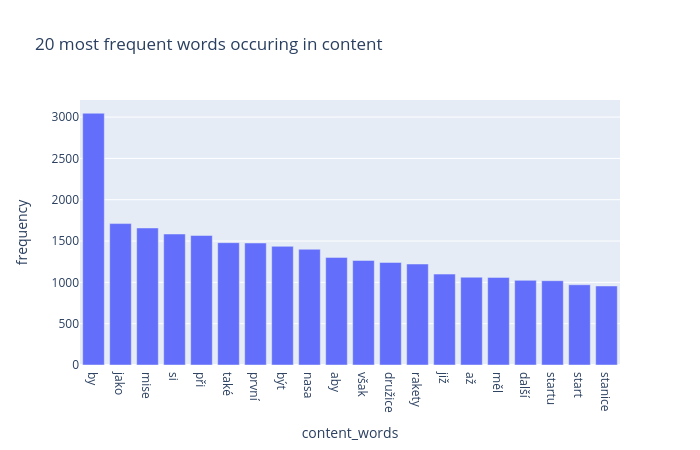

In [47]:
content_words = train_df["content"].apply(get_alpha_words)
content_word_freqs = get_freq_df(content_words, "content_words")
fig = px.bar(content_word_freqs.reset_index()[:20], x="content_words",
             y="frequency", title="20 most frequent words occuring in content")
fig.show()

<p>
    Looking at frequency of words we can see that typical czech wods occur often with `by` occuring the most often. (note: stop words are not included)
</p>

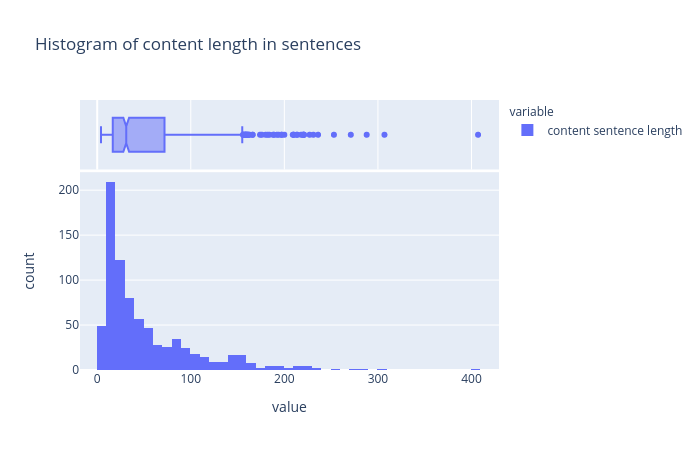

In [48]:
content_sentence_len = train_df["content"].apply(lambda s: s.count(".") + s.count("!") + s.count("?"))
content_sentence_len.rename("content sentence length", inplace=True)
fig = px.histogram(content_sentence_len, title=f"Histogram of content length in sentences", marginal="box")
fig.show()

<p>
    When we look at sentence count we can see that most articles have between 10 and 19 sentences. However there are some outliers with many sentences.
</p>

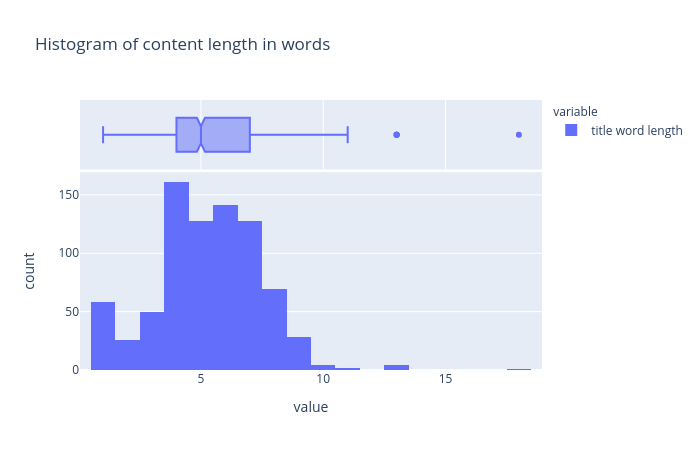

In [50]:
content_word_len = content_words.apply(len)
content_word_len.rename("content word length")
content_word_len.rename("content word length", inplace=True)
fig = px.histogram(title_word_len, title=f"Histogram of content length in words", marginal="box")
fig.show()

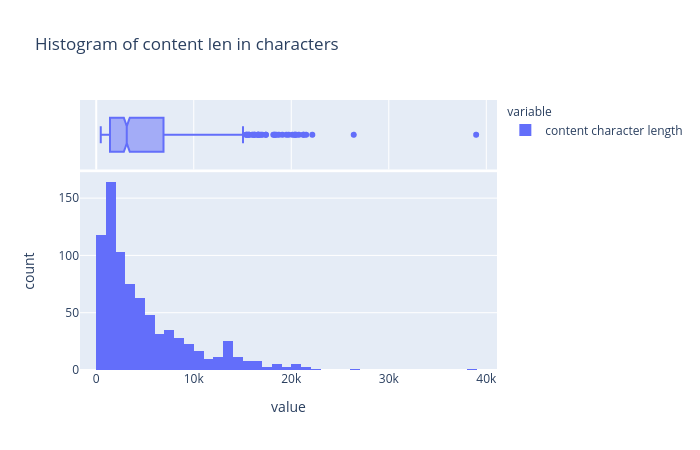

In [49]:
content_len = train_df["content"].apply(len)
content_len.rename("content character length", inplace=True)
fig = px.histogram(content_len, title=f"Histogram of content len in characters", marginal="box")
fig.show()

<p>
    We can see that there are two special outliers with really long texts.
</p>

In [51]:
content_len[content_len > 25_000] / train_df[content_len > 25_000]["paragraph_count"]

727    486.975000
369    440.116667
dtype: float64

In [52]:
(content_len / train_df["paragraph_count"]).describe()

count    800.000000
mean     354.632256
std       93.307798
min       47.562500
25%      298.429487
50%      342.320513
75%      402.875000
max      793.000000
dtype: float64

<p>
    As we can see the really long texts also have many paragraphs, so it does not seem that there are any errors.
</p>

## Feature Engineering
<p>
    We engineer new features that can be used to for modeling.
</p>
<p>
    First, we split the data into input vector (X) and output labels (y). For the input vector we only use the content.
</p>

In [34]:
train_X, train_y = train_df[["content"]], train_df["author"]
validation_X, validation_y = validation_df[["content"]], validation_df["author"]
test_X, test_y = test_df[["content"]], test_df["author"]

train_X

,content
999,musíte uznat oproti minulým dvěma týdnům tento...
998,návrh by mohlo jmenovat americké vozítko vyraz...
997,další měsíc uběhl jako voda aje čas rekapitula...
996,s tím blížil moment příletu nového modulu miru...
995,íránci letos pokoušejí opakovaně vypustit něja...
...,...
204,v posledních dnech zažívali celou řadu odkladů...
203,začátku září těšili působivý start rakety delt...
201,nasa aspacex dohodly posunutí startu první ost...
202,vozítko perseverance několik měsíců poletí mez...


<p>
    Because we are going to use DNN as a model, we can use keras's Tokenizer to fit training data.
</p>

In [35]:
MAX_WORDS = 50000
MAX_SEQUENCE_LEN = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters="\t\n")
tokenizer.fit_on_texts(train_X["content"].values)
print(f"Unique tokens: {len(tokenizer.word_index)}")

Unique tokens: 83835


<p>
    We pad the sentences to max length.
</p>

In [36]:
def tokenize(X : pd.DataFrame):
    """Tokenizes and pads X dataframe's content column."""
    
    result = tokenizer.texts_to_sequences(X["content"].values)
    return pad_sequences(result, maxlen=MAX_SEQUENCE_LEN)

train_X = tokenize(train_X)
validation_X = tokenize(validation_X)
test_X = tokenize(test_X)

train_X.shape

(800, 250)

<p>
    We one hot encode the labels.
</p>

In [37]:
labels = np.array(list(df["author"].unique()))
encoder = OneHotEncoder().fit(labels.reshape(-1, 1))
train_y = encoder.transform(np.array(train_y).reshape(-1, 1)).todense()
validation_y = encoder.transform(np.array(validation_y).reshape(-1, 1)).todense()
test_y = encoder.transform(np.array(test_y).reshape(-1, 1)).todense()

train_y

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]])

# Modeling
<p>
    We construct and train the network.
</p>

In [38]:
# metrics taken from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    """Calculates recall."""
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    """Calculates precision."""
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    """Calculates f1 score."""
    
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=train_X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(labels), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", recall_m, precision_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 18)                1818      
Total params: 5,082,218
Trainable params: 5,082,218
Non-trainable params: 0
_________________________________________________________________


In [39]:
EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(train_X, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(validation_X, validation_y),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

Epoch 1/10
13/13 [==============================] - 4s 279ms/step - loss: 2.6801 - accuracy: 0.5875 - recall_m: 0.0072 - precision_m: 0.0769 - f1_m: 0.0132 - val_loss: 1.2408 - val_accuracy: 0.7500 - val_recall_m: 0.7378 - val_precision_m: 0.7378 - val_f1_m: 0.7378
Epoch 2/10
13/13 [==============================] - 3s 249ms/step - loss: 1.4317 - accuracy: 0.7075 - recall_m: 0.7115 - precision_m: 0.7115 - f1_m: 0.7115 - val_loss: 1.1794 - val_accuracy: 0.7500 - val_recall_m: 0.7378 - val_precision_m: 0.7378 - val_f1_m: 0.7378
Epoch 3/10
13/13 [==============================] - 3s 257ms/step - loss: 1.2480 - accuracy: 0.7075 - recall_m: 0.7043 - precision_m: 0.7043 - f1_m: 0.7043 - val_loss: 1.1390 - val_accuracy: 0.7500 - val_recall_m: 0.7378 - val_precision_m: 0.7378 - val_f1_m: 0.7378
Epoch 4/10
13/13 [==============================] - 3s 248ms/step - loss: 1.1645 - accuracy: 0.7075 - recall_m: 0.7031 - precision_m: 0.7084 - f1_m: 0.7057 - val_loss: 1.1431 - val_accuracy: 0.7500 - va

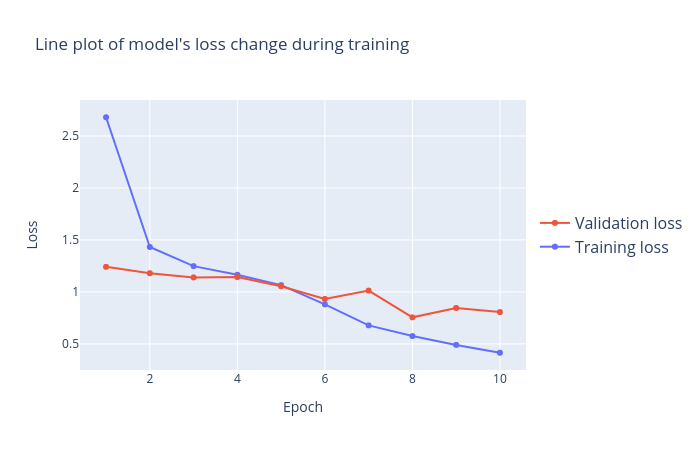

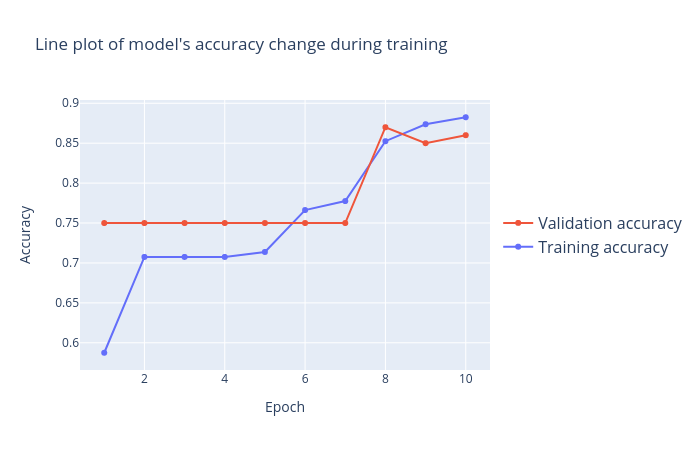

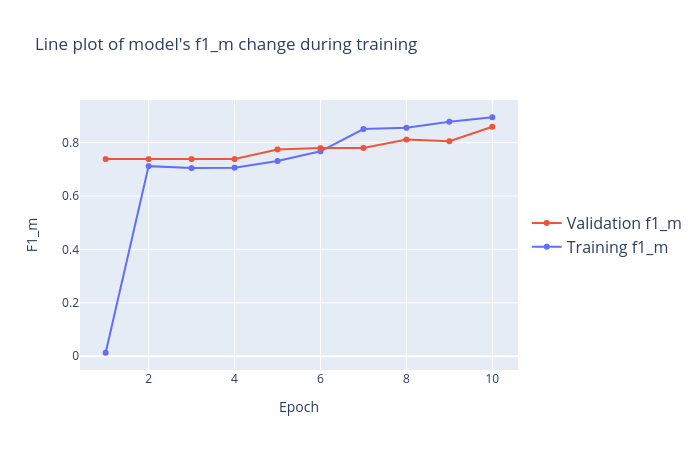

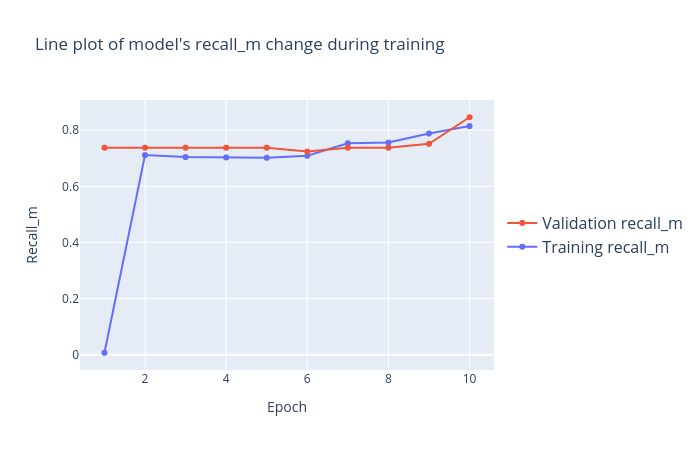

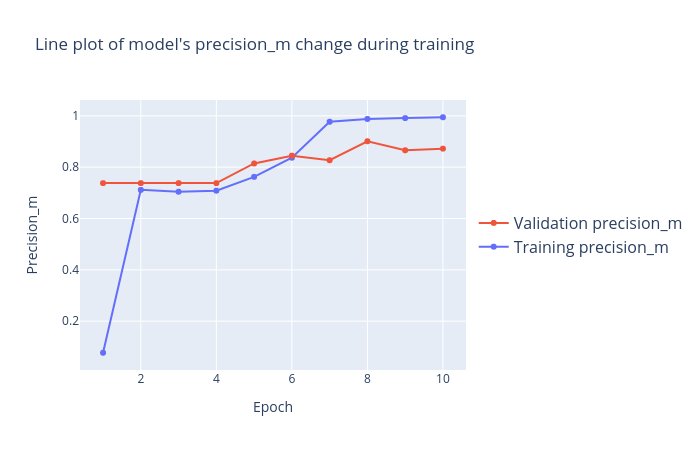

In [40]:
def plot_history_progress(model_history : Dict[str, List[float]], key: str, validation_prefix: str = "val_"):
    """Compares metric scores of validation and training data based on model history specified by given key."""
    
    train_key = key
    validation_key = f"{validation_prefix}{key}"
    train = model_history[key]
    validation = model_history[validation_key]
    epochs = [i + 1  for i in range(len(train))]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train, name=f"Training {key}"))
    fig.add_trace(go.Scatter(x=epochs, y=validation, name=f"Validation {key}"))
    fig.update_traces(hoverinfo='text+name', mode='lines+markers')
    fig.update_layout(title=f"Line plot of model's {key} change during training",
        xaxis_title="Epoch",
        yaxis_title=key.capitalize(),
        legend=dict(y=0.5, traceorder='reversed', font_size=16)
    )
    fig.show()
    
plot_history_progress(history.history, "loss")
plot_history_progress(history.history, "accuracy")
plot_history_progress(history.history, "f1_m")
plot_history_progress(history.history, "recall_m")
plot_history_progress(history.history, "precision_m")

<p>
    The model achieved 85.90% F1 score on the validation dataset.
</p>

# Evaluation
<p>
    We evaluate the model on test data and compare it to some baseline predictors.
</p>

## Baseline Predictors

In [41]:
random_baseline = DummyClassifier(strategy="uniform", random_state=SEED).fit(train_X, train_y)
most_frequent_baseline = DummyClassifier(strategy="most_frequent", random_state=SEED).fit(train_X, train_y)
stratified_baseline = DummyClassifier(strategy="stratified", random_state=SEED).fit(train_X, train_y)

## Comparison

In [42]:
pred_y = np.argmax(model.predict(test_X), axis=1)
random_pred_y = np.argmax(random_baseline.predict(test_X), axis=1)
frequent_pred_y = np.argmax(most_frequent_baseline.predict(test_X), axis=1)
stratified_pred_y = np.argmax(stratified_baseline.predict(test_X), axis=1)
true_y = np.argmax(np.asarray(test_y), axis=1)

In [43]:
type(true_y)

numpy.ndarray

In [44]:
model.evaluate(test_X, test_y)

4/4 [==============================] - 0s 35ms/step - loss: 1.4783 - accuracy: 0.7900 - recall_m: 0.8281 - precision_m: 0.8334 - f1_m: 0.8307


[1.4782929420471191,
 0.7900000214576721,
 0.828125,
 0.8334173560142517,
 0.8307291269302368]

In [45]:
def get_metrics_df(predictions: List[np.ndarray], predictor_names: List[str],
                   true_y : np.ndarray) -> pd.DataFrame:
    """Returns a dataframe with all the metrics as columns and predictors as rows."""
    
    rows = []
    for pred_y in predictions:
        row = [
            accuracy_score(true_y, pred_y),
            balanced_accuracy_score(true_y, pred_y),
            f1_score(true_y, pred_y, average="micro"),
            f1_score(true_y, pred_y, average="weighted"),
            precision_score(true_y, pred_y, average="micro"),
            recall_score(true_y, pred_y, average="micro"),
            cohen_kappa_score(true_y, pred_y),
        ]
        rows.append(row)
    metrics = [
        "accuracy", "balanced accuracy", "f1 score",
        "weighted f1 score", "precision",
        "recall", "cohen kappa"
    ]
    return pd.DataFrame(rows, columns=metrics, index=predictor_names)

get_metrics_df([pred_y, random_pred_y, frequent_pred_y, stratified_pred_y],
               ["neural network", "random baseline", "most frequent baseline", "stratified baseline"],
               true_y
              )

/home/dominik/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning:

y_pred contains classes not in y_true

/home/dominik/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning:

y_pred contains classes not in y_true



,accuracy,balanced accuracy,f1 score,weighted f1 score,precision,recall,cohen kappa
neural network,0.79,0.269841,0.79,0.716533,0.79,0.79,0.511855
random baseline,0.36,0.059701,0.36,0.392195,0.36,0.36,-0.036269
most frequent baseline,0.67,0.111111,0.67,0.537605,0.67,0.67,0.000000
stratified baseline,0.60,0.099502,0.60,0.505660,0.60,0.60,-0.056803


<p>
    The neural network achieves weighted 71.65% f1 score and unweighted (micro) 79% f1 score. Overall, the neural network performs better than the baseline models in each metric.
</p>

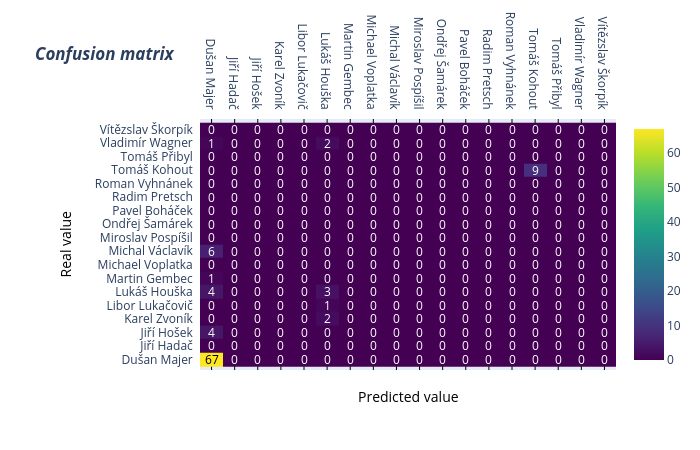

In [46]:
labels = list(encoder.categories_[0])
matrix = confusion_matrix(true_y, pred_y, labels=[i for i in range(len(labels))])
# change each element of z to type string for annotations
matrix_text = [[str(y) for y in x] for x in matrix]

# set up figure 
fig = ff.create_annotated_heatmap(matrix, x=labels, y=labels,
                                  annotation_text=matrix_text,
                                  colorscale='Viridis'
                                 )

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

<p>
    In the confusion matrix, y coordinate describes the real value and x coordinate describes the predicted value. When we look at the confusion matrix we can see that the most often occurring class, `Dušan Majer` is predicted correctly 67 times out of 67 times. `Jiri Hosek`, `Martin Gembec`, and `Michal Václavík` are predicted correctly 0 times out of 4, 1, and 6 cases respectively. Each time they are predicted as `Dušan Majer`. `Lukáš Houska` is predicted correctly 3 out of 7 times, while the incorrect predictions are always `Dušan Majer`. `Vladimír Wagner` is always predicted incorrectly, once as `Dušan Majer` and the other two times as `Lukáš Houska`. `Tomáš Kohout` is predicted correctly 9 out 9 times. 
</p>
<p>
    Overall we can conclude that the model is very good at predicting the major class, `Dušan Majer`. But for the minority clases, except `Tomáš Kohout`, the model is not as succesful. This can be partially attributed to imbalanced training dataset and the model sometimes not having enough articles for the authors to generalize well. The imbalanced training dataset could be solved by SMOTE oversampling and/or undersampling. Including other features somehow in the models might also help, for example features extracted from the date like season, quarter, month. 
</p>